# Hybrid CNN-RNN for Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imshow
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

Import data and display some information.

In [ ]:
df_train = pd.read_csv('data/mnist/mnist_train.csv')
df_test = pd.read_csv('data/mnist/mnist_test.csv')
df_train.head(2)

In [ ]:
print(f'the flattened images are vectors of {df.values[0,1:].shape[0]} elements')
side = np.sqrt(df.values[0,1:].shape[0]).astype('int')
print(f'the normal images will have dimension: {side} x {side}')

Visualize a few images

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
imshow(df.values[0,1:].reshape((28,28)))
plt.subplot(1,3,2)
imshow(df.values[3,1:].reshape((28,28)))
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
imshow(df.values[10,1:].reshape((28,28)))
plt.subplot(1,3,2)
imshow(df.values[13,1:].reshape((28,28)))

Prepare dataset for pytorch.

In [3]:
#class with data conversion function
class mnist_dataprep_conv1d(Dataset):
    def __init__(self,array):
        self.x = array[:,1:]                             #first column is labels
        self.x = torch.FloatTensor(self.x)
        self.x = self.x.reshape(self.x.shape[0],1,self.x.shape[1]) #CNN1d takes shape [n_batches,n_channels,seq_len]
        
        self.y = array[:,0]                #labels are on first column
        self.y = torch.LongTensor(self.y)  # they need to be in long format, not float
        
        self.n_samples = self.x.shape[0]   #this attribute might come in handy
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    
    
#convert data using custom function
train = mnist_dataprep_conv1d(df_train.values[:-1000])
val = mnist_dataprep_conv1d(df_train.values[-1000:])
test = mnist_dataprep_conv1d(df_test.values)

#use dataloader to divide data into batches
trainloader = DataLoader(train,batch_size=100)
valloader = DataLoader(val,batch_size=100)
testloader = DataLoader(test,batch_size=100)

Hybrid neural network architecture.

In [53]:
class CNN_RNN(nn.Module):
    def __init__(self,out_channels=10,kernel_size=4):
        super(CNN_RNN,self).__init__()
        self.conv1 = nn.Conv1d(1,out_channels,kernel_size=kernel_size)
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        
        self.rnn = nn.RNN(input_size=10, hidden_size=100, num_layers=1, batch_first=True)
        self.fc = nn.Linear(195*100,10)           #[seq_len*hidden_size,n_classes]
        
        self.conv2 = nn.Conv1d(out_channels,out_channels*5,kernel_size=kernel_size)
        self.pool2 = nn.MaxPool1d(kernel_size=4)
        self.flat = nn.Flatten()
        self.out = nn.Linear(19500,10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = x.reshape(x.shape[0],x.shape[2],x.shape[1])
        x,h = self.rnn(x)
        x = self.flat(x)
        #x = self.fc(x)
        #x = self.conv2(x)
        #x = self.pool2(x)
        #x = self.relu(x)
        #x = self.flat(x)
        x = self.out(x)
        
        return x

Instantiate model and initialize some parameters.

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-2

model = CNN_RNN()
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

CNN_RNN(
  (conv1): Conv1d(1, 10, kernel_size=(4,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (rnn): RNN(10, 100, batch_first=True)
  (fc): Linear(in_features=19500, out_features=10, bias=True)
  (conv2): Conv1d(10, 50, kernel_size=(4,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten()
  (out): Linear(in_features=19500, out_features=10, bias=True)
  (relu): ReLU()
)


Train hybrid CNN-RNN model.

In [69]:
model.train()
agg_loss = []
n_epochs = 3
for epoch in range(1,n_epochs+1):
    epoch_loss = 0
    n_batches = 0
    for x,y in trainloader:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds,y)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss/n_batches
    agg_loss.append(epoch_loss)
    print(f'Epoch:{epoch+0:03} | Loss:{epoch_loss}')

1
2
3
4


Plot loss curve:

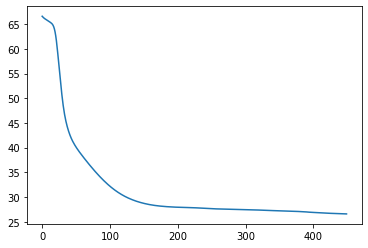

In [90]:
plt.plot(agg_loss)
plt.title('Loss Curve');

Make predictions and compute accuracy.

In [89]:
#make predictions
preds = model(test.x)
preds = torch.argmax(preds,dim=1)

#compute and print accuracy
correct = (preds == test.y).sum()    #how many correct predictions
accuracy = correct.numpy()/len(preds)#number of correct preds divided by total elements
print('accuracy: ', accuracy)

0.9059
